In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
data = pd.read_csv('train.csv')
data = np.array(data)
dataFrame = pd.DataFrame(data)

In [4]:
def splitData(data: np.ndarray, train_percent=0.8):
    m, n = data.shape
    numSplit = int(42000 * train_percent)
    
    train = data[0:numSplit].T
    y_train = train[0:1]
    x_train = train[1:n] / 255
    
    test = data[numSplit:m].T
    y_test = test[0:1]
    x_test = test[1:n] / 255
    
    return x_train, y_train, x_test, y_test
   
x_train, y_train, x_test, y_test = splitData(data)
print(f'X_train = {x_train.shape} | Y_train = {y_train.shape}')
print(f'X_test = {x_test.shape}   | Y_test = {y_test.shape}')

X_train = (784, 33600) | Y_train = (1, 33600)
X_test = (784, 8400)   | Y_test = (1, 8400)


In [5]:
def init_parameter(m: int, node_per_layer=10):
    
    w1 = np.random.rand(node_per_layer, m) - 0.5
    b1 = np.random.rand(node_per_layer, 1) - 0.5
    
    w2 = np.random.rand(node_per_layer, node_per_layer) - 0.5
    b2 = np.random.rand(node_per_layer, 1) - 0.5
    
    return w1, b1, w2, b2

def ReUL(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z)

def ReUL_der(z: np.ndarray) -> np.ndarray:
    return z >= 0

def softMax(z: np.ndarray) -> np.ndarray:
    return np.exp(z) / np.sum(np.exp(z), axis=0)

In [6]:
def forward_propagation(x: np.ndarray, 
                        w1: np.ndarray, b1: np.ndarray, 
                        w2: np.ndarray, b2: np.ndarray):
    
    z1 = w1 @ x + b1
    a1 = ReUL(z1)
    
    z2 = w2 @ a1 + b2
    a2 = softMax(z2)
    
    return z1, a1, z2, a2

def Y_boolean_vector(y):
    boolean = np.zeros([y.size, 10]) # (33600, 10)
    boolean[np.arange(y.size), y] = 1
    boolean = boolean.T
    return boolean # (10, 33600)

In [7]:
def backward_propagation(x: np.ndarray, y: np.ndarray,
                         z1: np.ndarray, w1: np.ndarray, a1: np.ndarray,
                         z2: np.ndarray, w2: np.ndarray, a2: np.ndarray):
    m = y.size
    dz_2 = a2 - Y_boolean_vector(y)
    # print(f'dz_2 = {dz_2.shape}')
    dw_2 = dz_2 @ a1.T / m
    # print(f'dw_2 = {dw_2.shape}')
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / m
    # print(f'db_2 = {db_2.shape}')
    dz_1 = w2.T @ dz_2 * ReUL_der(z1)
    # print(f'dz_1 = {dz_1.shape}')
    dw_1 = dz_1 @ x.T / m
    # print(f'dw_1 = {dw_1.shape}')
    db_1 = np.sum(dz_1) / m
    # print(f'db_1 = {db_1.shape}')
    return dw_1, db_1, dw_2, db_2

def update_parameters(w1: np.ndarray, b1: np.ndarray, w2: np.ndarray, b2: np.ndarray,
                     dw_1: np.ndarray, db_1: np.ndarray, dw_2: np.ndarray, db_2: np.ndarray,
                     alpha: float):
    b1 = b1 - alpha * db_1
    b2 = b2 - alpha * db_2
    
    w2 = w2 - alpha * dw_2
    w1 = w1 - alpha * dw_1
    return w1, b1, w2, b2

In [8]:
def prediction(a2: np.ndarray):
    return np.argmax(a2, 0)

def accuracy(predictions, y: np.ndarray):
    return np.sum(predictions == y) / y.size

def gradient_descent(X: np.ndarray, Y: np.ndarray, alpha: float, iterations: int):
    w1, b1, w2, b2 = init_parameter(X.shape[0])
    
    for i in range(iterations):
        z1, a1, z2, a2 = forward_propagation(X, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = backward_propagation(X, Y, z1, w1, a1, z2, w2, a2)
        w1, b1, w2, b2 = update_parameters(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = prediction(a2)
            print(f'Accuracy: {accuracy(predictions, Y)}')
            
    return w1, b1, w2, b2

In [9]:
def make_predictions(X: np.ndarray, 
                     w1: np.ndarray, b1: np.ndarray, 
                     w2: np.ndarray, b2: np.ndarray):
    
    _, _, _, a2 = forward_propagation(X, w1, b1, w2, b2)
    predictions = prediction(a2)
    return predictions

def test_prediction(index: int, 
                    w1: np.ndarray, b1: np.ndarray, 
                    w2: np.ndarray, b2: np.ndarray):
    
    prediction = make_predictions(x_train[:, index, None], w1, b1, w2, b2)
    label = y_train[0][index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = x_train[:, index, None]
    current_image = current_image.reshape((28, 28)) * 255
    
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
def export_parameters_as_csv(W1: np.ndarray, B1: np.ndarray, 
                      W2: np.ndarray, B2: np.ndarray,
                      alpha: float, iterations: int):
    
    file_path = ['w1', 'b1', 'w2', 'b2']
    parameters_export = [W1, B1, W2, B2]

    for i in range(len(file_path)):
        m, n = parameters_export[i].shape
        file_path[i] = 'Parameters/' + file_path[i] + f'_{m}x{n}_a{alpha}_i{iterations}' + '.csv'
        
    print(file_path)
    
    for i in range(len(file_path)):
        np.savetxt(file_path[i], parameters_export[i], delimiter=',')

In [11]:
w1, b1, w2, b2 = gradient_descent(x_train, y_train, 0.1, 1500)

Iteration:  0
Accuracy: 0.11648809523809524
Iteration:  100
Accuracy: 0.6519047619047619
Iteration:  200
Accuracy: 0.7730952380952381
Iteration:  300
Accuracy: 0.8161309523809523
Iteration:  400
Accuracy: 0.8395535714285715
Iteration:  500
Accuracy: 0.8533928571428572
Iteration:  600
Accuracy: 0.8623511904761905
Iteration:  700
Accuracy: 0.8694642857142857
Iteration:  800
Accuracy: 0.8751785714285715
Iteration:  900
Accuracy: 0.8798214285714285
Iteration:  1000
Accuracy: 0.883125
Iteration:  1100
Accuracy: 0.8872619047619048
Iteration:  1200
Accuracy: 0.890327380952381
Iteration:  1300
Accuracy: 0.8927380952380952
Iteration:  1400
Accuracy: 0.8951488095238095


In [12]:

_, _, _, a2_test = forward_propagation(x_test, w1, b1, w2, b2)

predictions_test = prediction(a2_test)
print(f'DataSet Accuracy: {accuracy(predictions_test, y_test)}')

# export_parameters_as_csv(w1, b1, w2, b2, 0.01, 10001)

DataSet Accuracy: 0.8964285714285715


In [13]:
def gradient_descent_2(X: np.ndarray, Y: np.ndarray, 
                     w1: np.ndarray, b1: np.ndarray, w2: np.ndarray, b2: np.ndarray,
                     alpha: float, iterations: int):
    
    for i in range(iterations):
        z1, a1, z2, a2 = forward_propagation(X, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = backward_propagation(X, Y, z1, w1, a1, z2, w2, a2)
        w1, b1, w2, b2 = update_parameters(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = prediction(a2)
            print(f'Accuracy: {accuracy(predictions, Y)}')
            
    return w1, b1, w2, b2

In [17]:
w1_2, b1_2, w2_2, b2_2 = gradient_descent_2(x_train, y_train, w1, b1, w2, b2, 0.1, 1000)

Iteration:  0
Accuracy: 0.8971428571428571
Iteration:  100
Accuracy: 0.8993452380952381
Iteration:  200
Accuracy: 0.9011011904761905
Iteration:  300
Accuracy: 0.9023511904761905
Iteration:  400
Accuracy: 0.9036904761904762
Iteration:  500
Accuracy: 0.9050892857142857
Iteration:  600
Accuracy: 0.9063988095238096
Iteration:  700
Accuracy: 0.9072916666666667
Iteration:  800
Accuracy: 0.90875
Iteration:  900
Accuracy: 0.9095833333333333


In [18]:
_, _, _, a2_test = forward_propagation(x_test, w1_2, b1_2, w2_2, b2_2)

predictions_test = prediction(a2_test)
print(f'DataSet Accuracy: {accuracy(predictions_test, y_test)}')

# export_parameters_as_csv(w1_2, b1_2, w2_2, b2_2, 0.1, 1000)

DataSet Accuracy: 0.9080952380952381


In [21]:
w1_3, b1_3, w2_3, b2_3 = gradient_descent_2(x_train, y_train, w1_2, b1_2, w2_2, b2_2, 0.3, 2000)

Iteration:  0
Accuracy: 0.910625
Iteration:  100
Accuracy: 0.9117559523809524
Iteration:  200
Accuracy: 0.9133630952380952
Iteration:  300
Accuracy: 0.9169047619047619
Iteration:  400
Accuracy: 0.9195535714285714
Iteration:  500
Accuracy: 0.9213690476190476
Iteration:  600
Accuracy: 0.9220535714285715
Iteration:  700
Accuracy: 0.9245238095238095
Iteration:  800
Accuracy: 0.9258630952380953
Iteration:  900
Accuracy: 0.9272916666666666
Iteration:  1000
Accuracy: 0.9283035714285715
Iteration:  1100
Accuracy: 0.929672619047619
Iteration:  1200
Accuracy: 0.930327380952381
Iteration:  1300
Accuracy: 0.9315178571428572
Iteration:  1400
Accuracy: 0.9324107142857143
Iteration:  1500
Accuracy: 0.933125
Iteration:  1600
Accuracy: 0.9338392857142858
Iteration:  1700
Accuracy: 0.9346130952380952
Iteration:  1800
Accuracy: 0.9354761904761905
Iteration:  1900
Accuracy: 0.9360119047619048


In [22]:
_, _, _, a2_test = forward_propagation(x_test, w1_3, b1_3, w2_3, b2_3)

predictions_test = prediction(a2_test)
print(f'DataSet Accuracy: {accuracy(predictions_test, y_test)}')

# export_parameters_as_csv(w1_3, b1_3, w2_3, b2_3, 1, 1000)

DataSet Accuracy: 0.9275


In [30]:
w1_4, b1_4, w2_4, b2_4 = gradient_descent_2(x_train, y_train, w1_3, b1_3, w2_3, b2_3, 0.5, 2000)

Iteration:  0
Accuracy: 0.936577380952381
Iteration:  100
Accuracy: 0.9354464285714286
Iteration:  200
Accuracy: 0.9369047619047619
Iteration:  300
Accuracy: 0.9373809523809524
Iteration:  400
Accuracy: 0.9394642857142858
Iteration:  500
Accuracy: 0.9403869047619048
Iteration:  600
Accuracy: 0.9410714285714286
Iteration:  700
Accuracy: 0.9416666666666667
Iteration:  800
Accuracy: 0.9427678571428572
Iteration:  900
Accuracy: 0.9423214285714285
Iteration:  1000
Accuracy: 0.9433630952380953
Iteration:  1100
Accuracy: 0.9439285714285715
Iteration:  1200
Accuracy: 0.9446130952380952
Iteration:  1300
Accuracy: 0.945297619047619
Iteration:  1400
Accuracy: 0.9453571428571429
Iteration:  1500
Accuracy: 0.9447916666666667
Iteration:  1600
Accuracy: 0.9460714285714286
Iteration:  1700
Accuracy: 0.9466071428571429
Iteration:  1800
Accuracy: 0.9463392857142857
Iteration:  1900
Accuracy: 0.9470535714285714


In [31]:
w1_5, b1_5, w2_5, b2_5 = gradient_descent_2(x_train, y_train, w1_4, b1_4, w2_4, b2_4, 0.5, 5000)

Iteration:  0
Accuracy: 0.9476190476190476
Iteration:  100
Accuracy: 0.9479761904761905
Iteration:  200
Accuracy: 0.9486904761904762
Iteration:  300
Accuracy: 0.9232440476190477
Iteration:  400
Accuracy: 0.9491964285714286
Iteration:  500
Accuracy: 0.9494642857142858
Iteration:  600
Accuracy: 0.9497619047619048
Iteration:  700
Accuracy: 0.9462797619047619
Iteration:  800
Accuracy: 0.9502678571428571
Iteration:  900
Accuracy: 0.934047619047619
Iteration:  1000
Accuracy: 0.9510416666666667
Iteration:  1100
Accuracy: 0.9516071428571429
Iteration:  1200
Accuracy: 0.9516666666666667
Iteration:  1300
Accuracy: 0.9517559523809523
Iteration:  1400
Accuracy: 0.9491666666666667
Iteration:  1500
Accuracy: 0.9521726190476191
Iteration:  1600
Accuracy: 0.9416369047619048
Iteration:  1700
Accuracy: 0.9528571428571428
Iteration:  1800
Accuracy: 0.9499107142857143
Iteration:  1900
Accuracy: 0.9531845238095238
Iteration:  2000
Accuracy: 0.9534523809523809
Iteration:  2100
Accuracy: 0.9536607142857143
I

In [32]:
# final
m, n = data.shape
final = data[0:m].T
y_final = final[0:1]
x_final = final[1:n] / 255
_, _, _, a2_final = forward_propagation(x_final, w1_5, b1_5, w2_5, b2_5)

predictions_final = prediction(a2_final)
print(f'DataSet Accuracy: {accuracy(predictions_final, y_final)}')
    
file_path = ['w1', 'b1', 'w2', 'b2']
parameters_export = [w1_3, b1_3, w2_3, b2_3]

for i in range(len(file_path)):
    m_size, n_size = parameters_export[i].shape
    file_path[i] = 'Final_Parameters_95/' + file_path[i] + f'_{m_size}x{n_size}' + '.csv'
    
print(file_path)

for i in range(len(file_path)):
    np.savetxt(file_path[i], parameters_export[i], delimiter=',')

DataSet Accuracy: 0.949952380952381
['Final_Parameters_95/w1_10x784.csv', 'Final_Parameters_95/b1_10x1.csv', 'Final_Parameters_95/w2_10x10.csv', 'Final_Parameters_95/b2_10x1.csv']


Prediction:  [0]
Label:  0


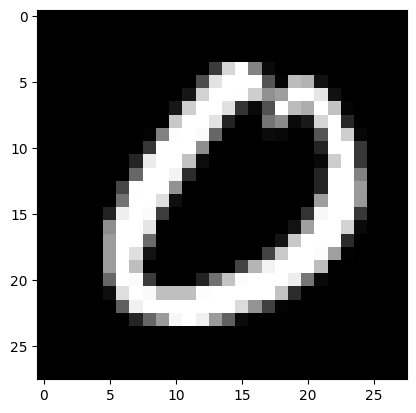

In [28]:
test_prediction(np.random.randint(0, 3000), w1_3, b1_3, w2_3, b2_3)

# Conclusion

## Accuracy
- Achieved an impressive accuracy of 93.92%.

## Model Architecture
- **Input Layer:** Consists of 784 nodes.
- **Hidden Layers:**
  1. First hidden layer: Rectified Linear Unit (ReUL) activation function, with 10 nodes.
  2. Second hidden layer: Softmax activation function, also with 10 nodes.
- **Output Layer:** Comprises 10 nodes for prediction.

## Model Parameters
- **w1:** Weight matrix with dimensions (10, 784).
- **b1:** Bias vector with dimensions (10, 1).
- **w2:** Weight matrix with dimensions (10, 10).
- **b2:** Bias vector with dimensions (10, 1).

These results demonstrate the effectiveness of the model architecture and the successful optimization of parameters, leading to a high level of accuracy in predictions.
